In [1]:
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
import warnings
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from dataset_tools import Dataset, lowpass_filter, extract_sensors, extract_features

In [2]:
warnings.filterwarnings("ignore")

# Loading & Extracting

In [3]:
person1 = Dataset('dataset/dataset_1.txt')
number_of_datasets = 19
everyone = []

In [4]:
for dataset_num in range(1,number_of_datasets+1):
    dataset = Dataset(f'dataset/dataset_{dataset_num}.txt')
    everyone.append(dataset)

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10| 11| 12| 13| 14|15 | 16| 17|   18| 19| 20| 21| 22| 23| 24|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Wrist:A1(X)|A2(Y)|A3(Z)|G1(x)|G2(Y)|G3(Z)|Chest:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Hip:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Ankle:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Type|

# Visualising

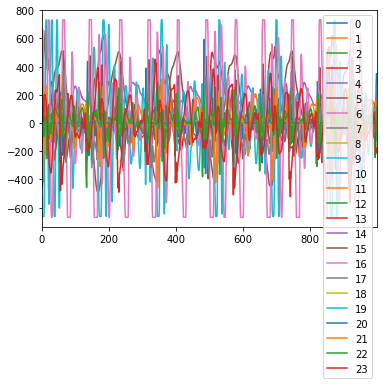

In [5]:
everyone[0].rope_jumping['all'][:1000].plot()

# Filtering

In [6]:
for idx, dataset in enumerate(everyone):
    print(idx, end=' ')
    lowpass_filter(dataset.data_frame, order=4, cutoff=5)
    dataset.extract_sensors(300)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

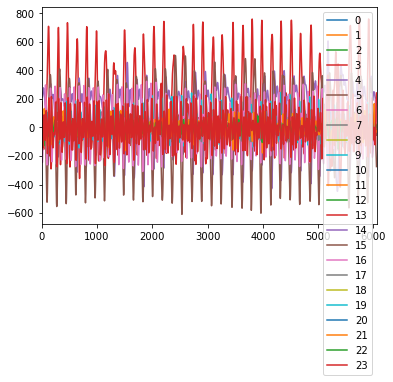

In [7]:
everyone[1].rope_jumping['all'].plot()

# Feature Extraction

In [8]:
window_size = 1000
features = [np.max, np.min, np.median, np.std, np.var]

#instantiating the testing and training set
all_train, all_test = everyone[0].extract_all_features(features, window_size)
for idx, dataset in enumerate(everyone):
    print(idx, end=' ')
    if idx==0: continue
    d_train, d_test = dataset.extract_all_features(features, window_size)
    all_train = all_train.append(d_train)
    all_test = all_test.append(d_test)


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

# Training & Testing Preprocessing

In [11]:
training_sensors = all_train.loc[:,all_train.columns !='activity']
training_activities = all_train.loc[:,:'activity':-1]
testing_sensors = all_test.loc[:,all_test.columns !='activity']
testing_activities = all_test.loc[:,:'activity':-1]

In [12]:
scaler = preprocessing.StandardScaler().fit(training_sensors)
training_sensors = scaler.transform(training_sensors)
testing_sensors = scaler.transform(testing_sensors)

# KNN

In [13]:
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(training_sensors, training_activities.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

In [14]:
knn_prediction = knn.predict(testing_sensors)
knn_accuracy = accuracy_score(testing_activities, knn_prediction)
print('Accuracy: ', knn_accuracy)
print(confusion_matrix(testing_activities, knn_prediction))

Accuracy:  0.9490229396771452
[[ 44   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 107  10   0   0   0   0   0   0   0   0   0   0]
 [  0  23  93   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  37   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  57   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  38   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  58   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  57   0   0   0   0   0]
 [  2   0   0   0   0   0   0   0  82   0  14   0   0]
 [  0   0   0   0   0   0   0   0   0 115   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0  54   0   0]
 [  1   0   0   0   0   0   0   0   0   0   5 258   0]
 [  0   0   0   0   0   0   0   0   0   0   1   0 117]]


# SVC

In [15]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                    {'kernel': ['linear'], 'C': [1e-3,1e-2, 1e-1, 1, 10, 100]}]
acc_scorer = make_scorer(accuracy_score)
grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)
grid_obj  = grid_obj.fit(training_sensors, training_activities.values.ravel())

In [16]:
clf = grid_obj.best_estimator_
clf.fit(training_sensors, training_activities.values.ravel())
svc_prediction = clf.predict(testing_sensors)
svc_accuracy = accuracy_score(testing_activities, svc_prediction)
print('Accuracy: ', svc_accuracy)
print(confusion_matrix(testing_activities, svc_prediction))

Accuracy:  0.9617672047578589
[[ 43   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0 112   5   0   0   0   0   0   0   0   0   0   0]
 [  0  18  98   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  37   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  57   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  38   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  58   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  57   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  90   0   8   0   0]
 [  0   0   0   0   0   0   0   0   0 115   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0  54   0   0]
 [  2   0   0   0   0   0   0   1   1   0   3 257   0]
 [  0   0   0   0   0   0   0   1   0   0   1   0 116]]


# Comparison

### SVC

In [19]:
print('SVC Accuracy: ', svc_accuracy)
confusion_matrix(testing_activities, svc_prediction)

SVC Accuracy:  0.9617672047578589


array([[ 43,   0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0],
       [  0, 112,   5,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  18,  98,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  37,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  57,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  38,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  58,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  57,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  90,   0,   8,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 115,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   4,   0,  54,   0,   0],
       [  2,   0,   0,   0,   0,   0,   0,   1,   1,   0,   3, 257,   0],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0,   0,   1,   0, 116]])

### KNN

In [20]:
print('KNN Accuracy: ', knn_accuracy)
confusion_matrix(testing_activities, knn_prediction)

KNN Accuracy:  0.9490229396771452


array([[ 44,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 107,  10,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  23,  93,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  37,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  57,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  38,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  58,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  57,   0,   0,   0,   0,   0],
       [  2,   0,   0,   0,   0,   0,   0,   0,  82,   0,  14,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 115,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   4,   0,  54,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   5, 258,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0, 117]])